<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/screws.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/ComputerVision/screws.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Something Screwy - image recognition, detection, and classification of screws

**By Neuromatch Academy**

__Content creators:__ [Joe Donovan](mailto:joe311@gmail.com)

__Production editor:__ Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

Useful link: 
NMA daily guide to projects - [https://deeplearning.neuromatch.io/projects/docs/project_guidance.html](https://deeplearning.neuromatch.io/projects/docs/project_guidance.html) 

The overall goal of the project is to learn about object recognition, classification, and detection. 
You'll start with simple networks, and potentially work up to larger pretained models. Your loss function is to optimize learning, not model performance.

---
# Setup

##  Install dependencies


In [1]:
# @title Install dependencies
!pip install scikit-image --quiet
!pip install torchsummary --quiet
!pip install Shapely --quiet

In [1]:
import os
import requests
import random
import json
import numpy as np
from skimage import io
from scipy import ndimage
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

##  Helper functions


In [18]:
# @title Helper functions
# helpful function for extracting rotated subimages etc
def unpack_bbox(bbox):
  #bbox as in the json/COCO data format (centerx, centery, width, height, theta is in radians)

  rot_center = np.array((bbox[1], bbox[0])).T
  width = bbox[3]
  height = bbox[2]
  theta = -bbox[4]+np.pi/2 #radians
  return rot_center, width, height, theta


def rotcorners_from_coords(rot_center, width, height, theta):
  rotation = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta))))

  wvec = np.dot(rotation, (width/2, 0))
  hvec = np.dot(rotation, (0, height/2))
  corner_points = rot_center + [wvec+hvec, wvec-hvec, -wvec+hvec, -wvec-hvec]
  return corner_points


def rotbbox_from_coords(rot_center, width, height, theta):
  corner_points = rotcorners_from_coords(rot_center, width, height, theta)
  rot_bbox = np.array((corner_points.min(0), corner_points.max(0))).astype(int)
  #constrain inside image
  rot_bbox[rot_bbox < 0] = 0
  return rot_bbox


def extract_subimg_bbox(im, bbox):
  return extract_subimg(im, *unpack_bbox(bbox))


def extract_subimg(im, rot_center, width, height, theta):
  rot_bbox = rotbbox_from_coords(rot_center, width, height, theta)
  #print(rot_bbox)
  subimg = im[rot_bbox[0,1]:rot_bbox[1,1],rot_bbox[0,0]:rot_bbox[1,0]]
  rotated_im = ndimage.rotate(subimg, np.degrees(theta)+180)
  newcenter = (np.array(rotated_im.shape)/2).astype(int)
  rotated_im = rotated_im[int(newcenter[0]-height/2):int(newcenter[0]+height/2), int(newcenter[1]-width/2):int(newcenter[1]+width/2), :3]  #drop alpha channel, if it's there
  
  return rotated_im

##  Choose device


In [3]:
# @title Choose device
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n")
  else:
    print("GPU is enabled in this notebook. \n")

  return device

##  Figure settings


In [4]:
# @title Figure settings
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec
from matplotlib import patches, transforms as plt_transforms

rcParams['figure.figsize'] = [16, 6]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
device = set_device()

GPU is enabled in this notebook. 



---
# Data loading
Let's start by downloading the data and taking a look at it  

Properly understanding and exploring the structure of your data is a crucial step to any project 

In [7]:
# Download dataset, took around 4 minutes for me
# 'https://www.mvtec.com/company/research/datasets/mvtec-screws'
import requests, tarfile

url = 'https://osf.io/ruca6/download'
tarname = 'mvtec_screws_v1.0.tar.gz'
if not os.path.isfile(tarname):
  print('Data archive downloading...')
  r = requests.get(url, stream=True)
  with open(tarname, 'wb') as fd:
    fd.write(r.content)
  print('Download completed.')

# unpack tar datafile
datapath = 'screwdata'
if not os.path.exists(datapath):
  with tarfile.open(tarname) as tar:
    tar.extractall(datapath)
  os.remove(tarname)

Data archive downloading...
Download completed.


In [8]:
# Some json files and a folder full of images
os.listdir(datapath)

['images',
 'mvtec_screws.hdict',
 'mvtec_screws.json',
 'mvtec_screws_splitted.hdict',
 'mvtec_screws_test.hdict',
 'mvtec_screws_test.json',
 'mvtec_screws_train.hdict',
 'mvtec_screws_train.json',
 'mvtec_screws_val.hdict',
 'mvtec_screws_val.json',
 'README_v1.0.txt']

In [ ]:
# There's some details in the readme
with open('screwdata/README_v1.0.txt') as f:
  file_contents = f.read()
  print(file_contents)

In [9]:
#Load the json file with the annotation metadata
with open(os.path.join(datapath, 'mvtec_screws.json')) as f:
  data = json.load(f)

print(data.keys())
print(data['images'][0])
print(data['annotations'][0])

dict_keys(['categories', 'images', 'annotations', 'licenses', 'info'])
{'file_name': 'screws_001.png', 'height': 1440, 'width': 1920, 'id': 1, 'license': 1}
{'area': 3440.97, 'bbox': [184.5, 876.313, 55, 62.5631, 0], 'category_id': 7, 'id': 1001, 'image_id': 1, 'is_crowd': 0}


In [11]:
#Load the images, and make some helpful dict to map the data
imgdir = os.path.join(datapath, 'images')

#remap images to dict by id
imgdict = {l['id']:l for l in data['images']}
#read in all images, can take some time
for i in imgdict.values():
  i['image'] = io.imread(os.path.join(imgdir, i['file_name']))[:, :,: 3]  # drop alpha channel, if it's there

# remap annotations to dict by image_id
from collections import defaultdict
annodict = defaultdict(list)
for annotation in data['annotations']:
  annodict[annotation['image_id']].append(annotation)

# setup list of categories
categories = data['categories']
ncategories = len(categories)
cat_ids = [i['id'] for i in categories]
category_names = {7:'nut', 3:'wood screw', 2:'lag wood screw', 8:'bolt',
                  6:'black oxide screw', 5:'shiny screw', 4:'short wood screw',
                  1:'long lag screw', 9:'large nut', 11:'nut', 10:'nut',
                  12:'machine screw', 13:'short machine screw' }

## Let's check out some data

In [120]:
#python program to check if a directory exists
import os
if not os.path.exists('screwdata/train'):
   os.makedirs('screwdata/train')
if not os.path.exists('screwdata/val'):
   os.makedirs('screwdata/val')

datapath = 'screwdata'
with open(os.path.join(datapath, 'mvtec_screws_train.json')) as f:
  data = json.load(f)

#Load the images, and make some helpful dict to map the data
imgdir = os.path.join(datapath, 'images')

#remap images to dict by id
imgdict = {l['id']:l for l in data['images']}
#read in all images, can take some time
for i in imgdict.values():
  i['image'] = io.imread(os.path.join(imgdir, i['file_name']))[:, :,: 3]  # drop alpha channel, if it's there

# remap annotations to dict by image_id
from collections import defaultdict
annodict = defaultdict(list)
for annotation in data['annotations']:
  annodict[annotation['image_id']].append(annotation)

# setup list of categories
categories = data['categories']
ncategories = len(categories)
cat_ids = [i['id'] for i in categories]
category_names = {7:'nut', 3:'wood_screw', 2:'lag_wood_screw', 8:'bolt',
                  6:'black_oxide_screw', 5:'shiny_screw', 4:'short_wood_screw',
                  1:'long_lag_screw', 9:'large_nut', 11:'nut', 10:'nut',
                  12:'machine_screw', 13:'short_machine_screw' }   
    
for imID in imgdict:
    x = list(imgdict.values())
    filename = "%s.txt" % x[imID-1]["file_name"][:10] #"screws_%03d.txt" % imID
    #print(filename)
    f = open(os.path.join(datapath, 'train', filename), "w")
    for i, annotation in enumerate(annodict[imID]):
        bbox = annotation['bbox']
        corners = rotcorners_from_coords(*unpack_bbox(bbox))
        DOTA = ""
        for x, y in corners:
            DOTA += "%d %d " % (x, y)
        DOTA += "%s " % category_names[annotation['category_id']]
        DOTA += "%s\n" % annotation['is_crowd']
        f.write(DOTA)
    f.close()

[[624.71495769 866.87124554]
 [854.10491403 866.72971192]
 [624.57708597 643.41628808]
 [853.96704231 643.27475446]]
[[1430.2723434   574.39248316]
 [1412.04691569  346.31551326]
 [1285.73308431  585.94248674]
 [1267.5076566   357.86551684]]
[[764.84794297 335.7697304 ]
 [934.76284054 335.58316376]
 [764.65515946 160.19283624]
 [934.57005703 160.0062696 ]]
[[ 957.24215217 1100.07901881]
 [1019.4985839  1099.98681696]
 [ 957.1554161  1041.51318304]
 [1019.41184783 1041.42098119]]
[[1385.30436391 1011.33843127]
 [1271.99655289  732.68345162]
 [1291.74344711 1049.38254838]
 [1178.43563609  770.72756873]]
[[417.86306211 582.63877933]
 [558.30086437 584.83666991]
 [418.64913563 532.41133009]
 [559.08693789 534.60922067]]
[[ 702.08551037 1315.64106481]
 [ 869.10430962 1062.82943395]
 [ 619.48369038 1261.07056605]
 [ 786.50248963 1008.25893519]]
[[1077.02591754  519.93106966]
 [1164.85099153  520.6102345 ]
 [1077.74900847  426.4257655 ]
 [1165.57408246  427.10493034]]
[[546.38384409 337.34646

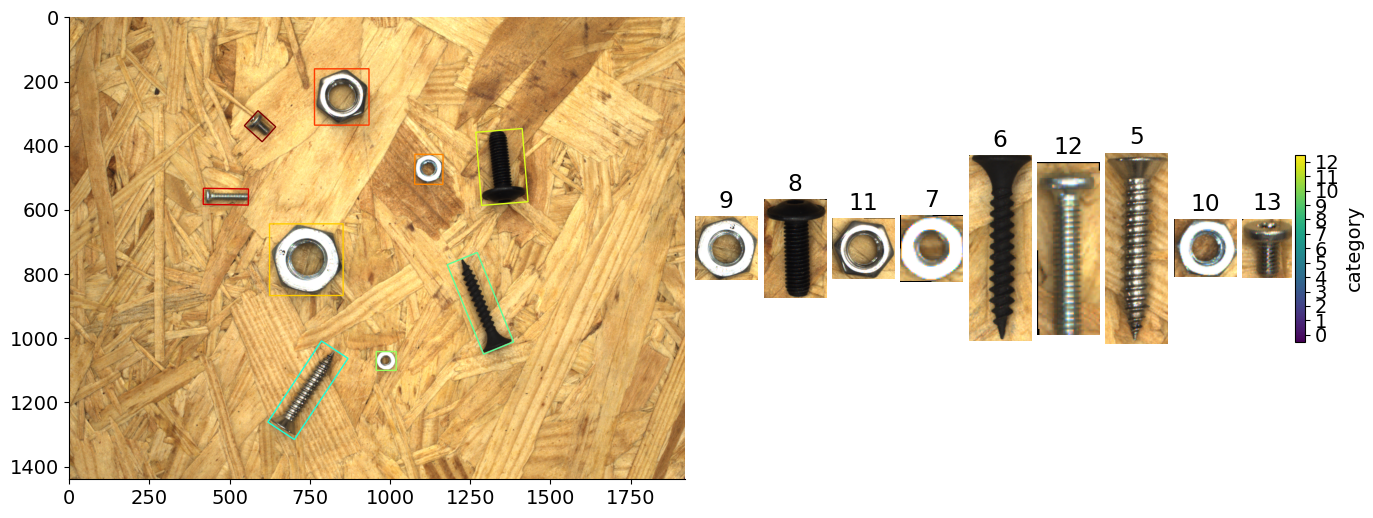

In [19]:
# Let's look at one image and it's associated annotations
imageid = 120
im = imgdict[imageid]['image']
gs = gridspec.GridSpec(1, 1 + len(annodict[imageid]),
                       width_ratios=[1,]+[.1]*len(annodict[imageid]),
                       wspace=.05)
plt.figure()
ax = plt.subplot(gs[0])
plt.imshow(im)
cmap_normal = plt.Normalize(0, ncategories)

for i, annotation in enumerate(annodict[imageid]):
  bbox = annotation['bbox']

  # plt.scatter(*rot_center)
  # plt.scatter(*corner_points.T, c='r')

  ax = plt.subplot(gs[0])
  color = plt.cm.jet(cmap_normal(annotation['category_id']))
  rect = patches.Rectangle((bbox[1] - bbox[3]/2 ,
                            bbox[0] - bbox[2]/2), bbox[3], bbox[2],
                           linewidth=1, edgecolor=color, facecolor='none')
  t = plt_transforms.Affine2D().rotate_around(bbox[1], bbox[0], -bbox[4]+np.pi/2)
  rect.set_transform(t + plt.gca().transData)
  ax.add_patch(rect)

  plt.subplot(gs[i + 1])
  rotated_im = extract_subimg_bbox(im, bbox)
  plt.imshow(rotated_im)
  plt.axis('off')
  plt.title(annotation['category_id'])

plt.colorbar(ticks=range(ncategories), label='category')
plt.clim(-0.5, ncategories - .5)
plt.show()

In [22]:
# create a dict mapping category id to all subimages, can take some time to run
cat_imgdict = defaultdict(list)
for img_id, image in imgdict.items():
  for annotation in annodict[img_id]:
    bbox = annotation['bbox']
    subimg = extract_subimg_bbox(image['image'], bbox)
    cat_imgdict[annotation['category_id']].append(subimg.copy())

In [23]:
# How many images are in each category?
for k, v  in cat_imgdict.items():
  print(f"Category ID {k} has {len(v)} items")  #f-strings are neat - see https://realpython.com/python-f-strings/

Category ID 7 has 365 items
Category ID 3 has 317 items
Category ID 2 has 314 items
Category ID 8 has 367 items
Category ID 6 has 393 items
Category ID 5 has 387 items
Category ID 4 has 315 items
Category ID 1 has 313 items
Category ID 9 has 320 items
Category ID 11 has 346 items
Category ID 10 has 347 items
Category ID 12 has 322 items
Category ID 13 has 321 items


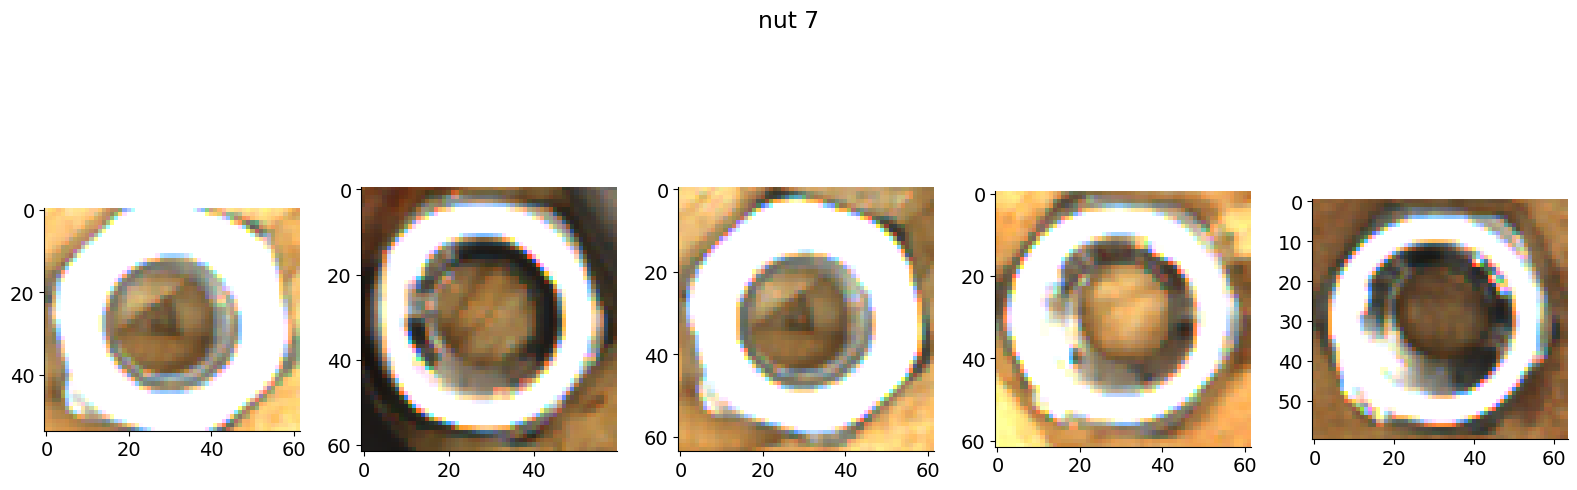

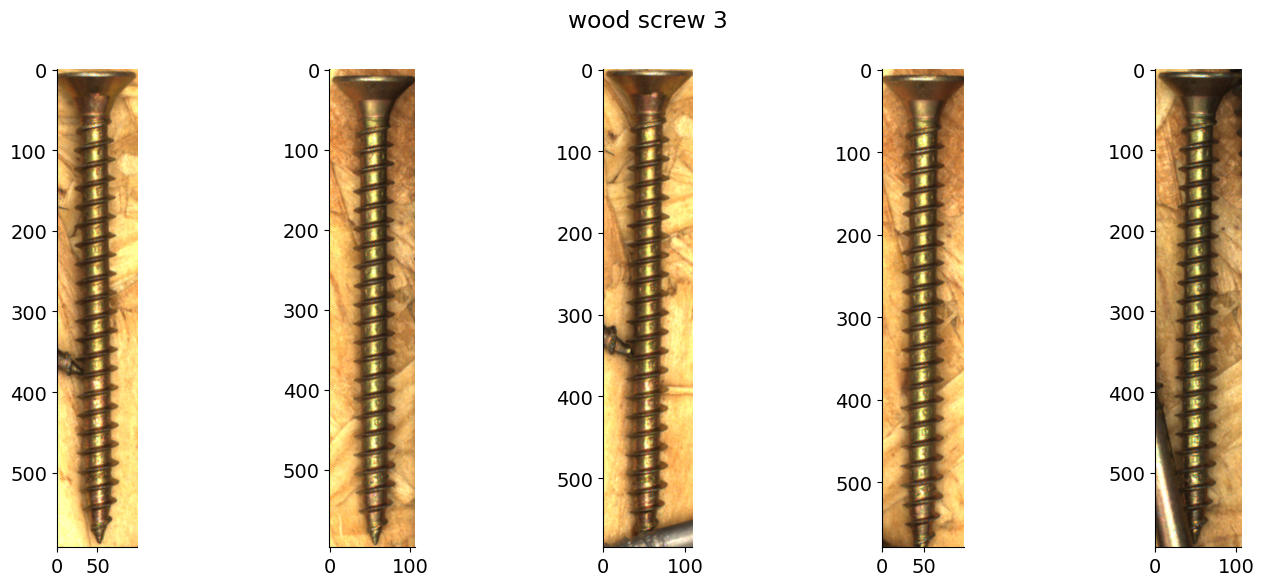

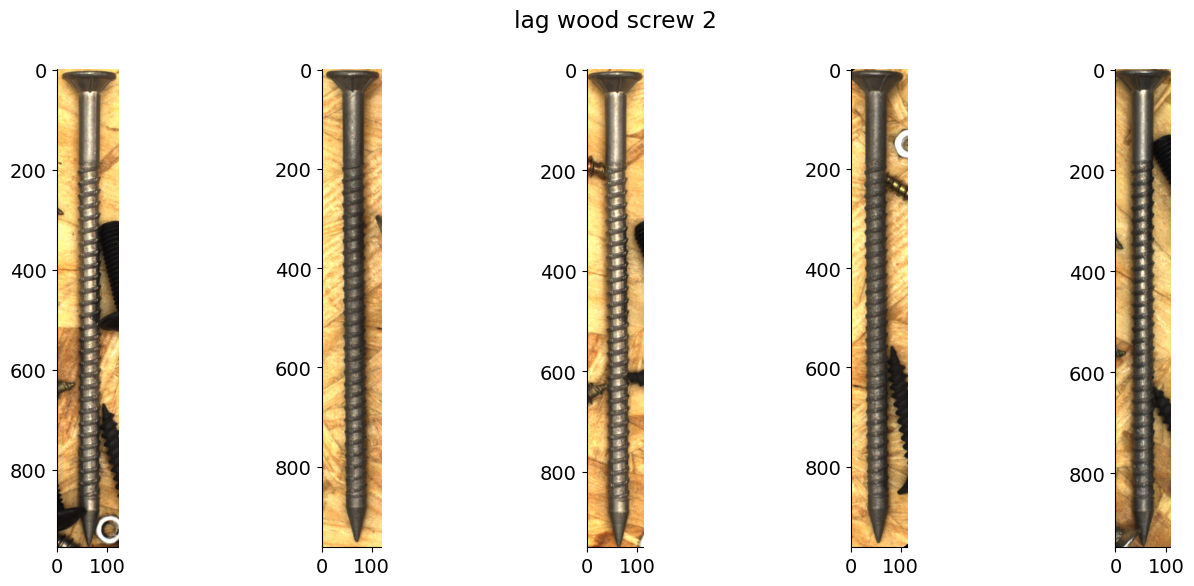

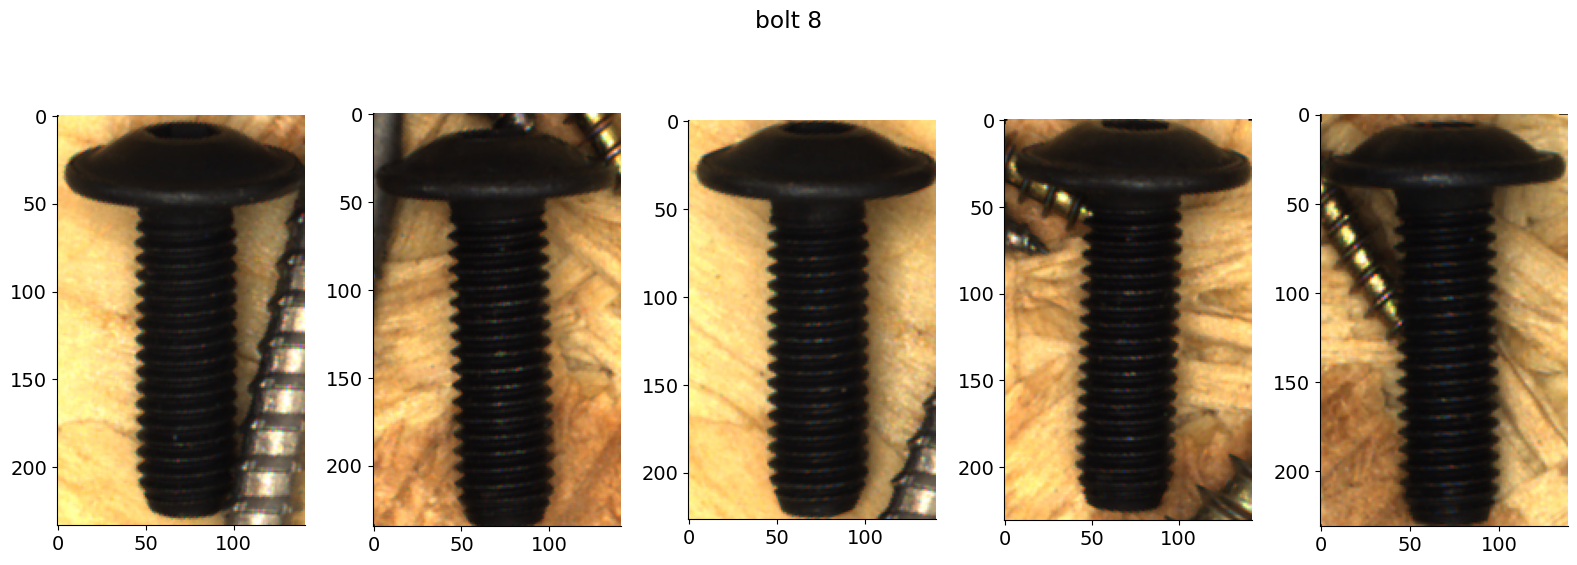

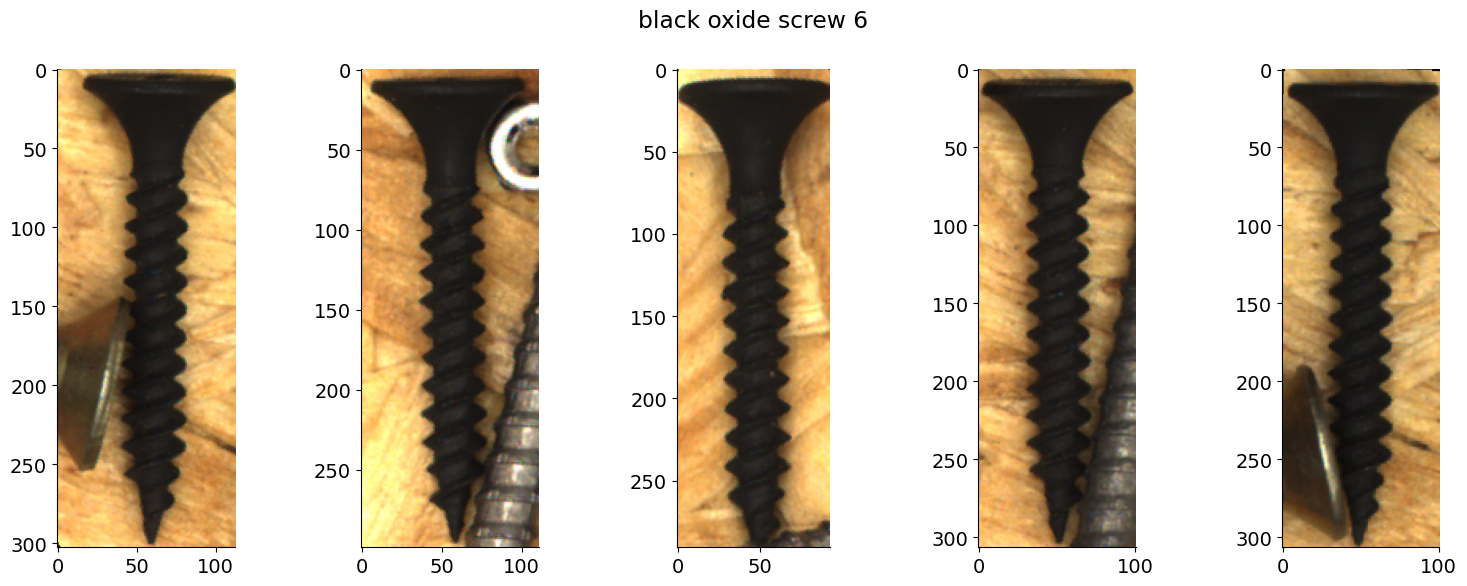

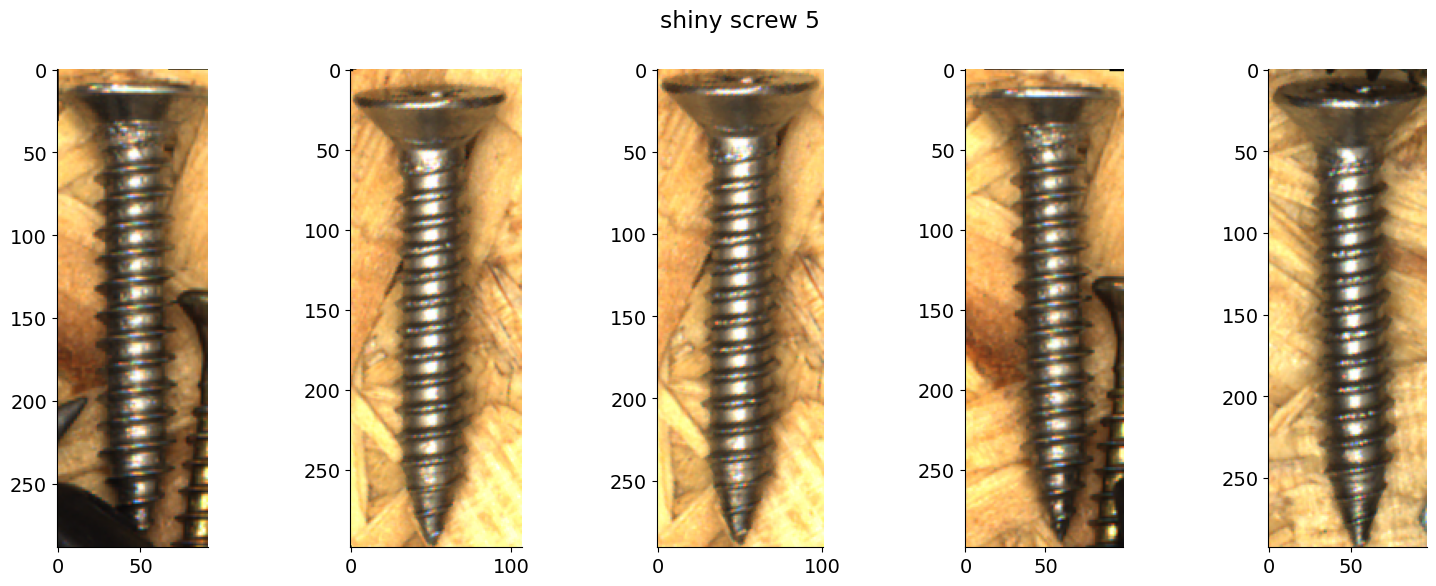

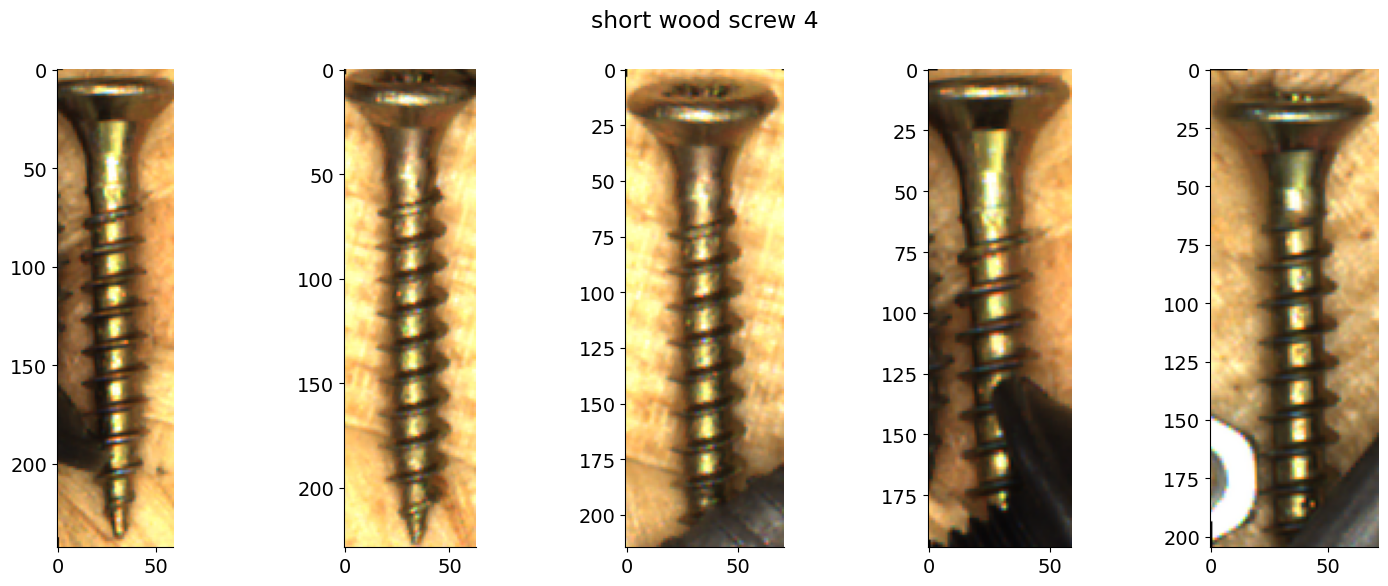

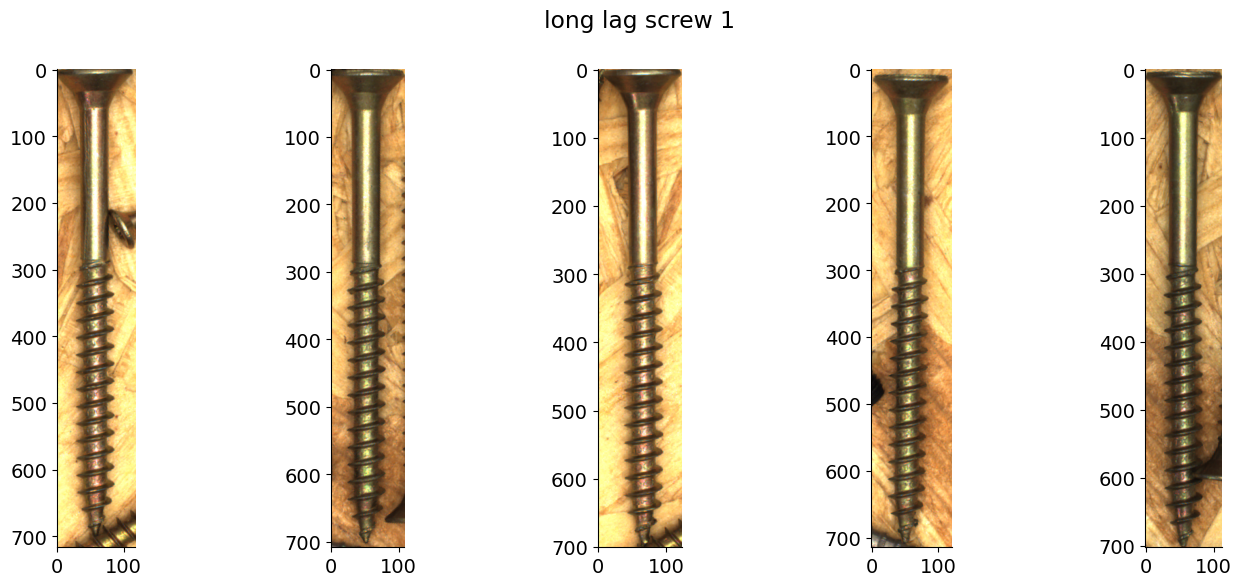

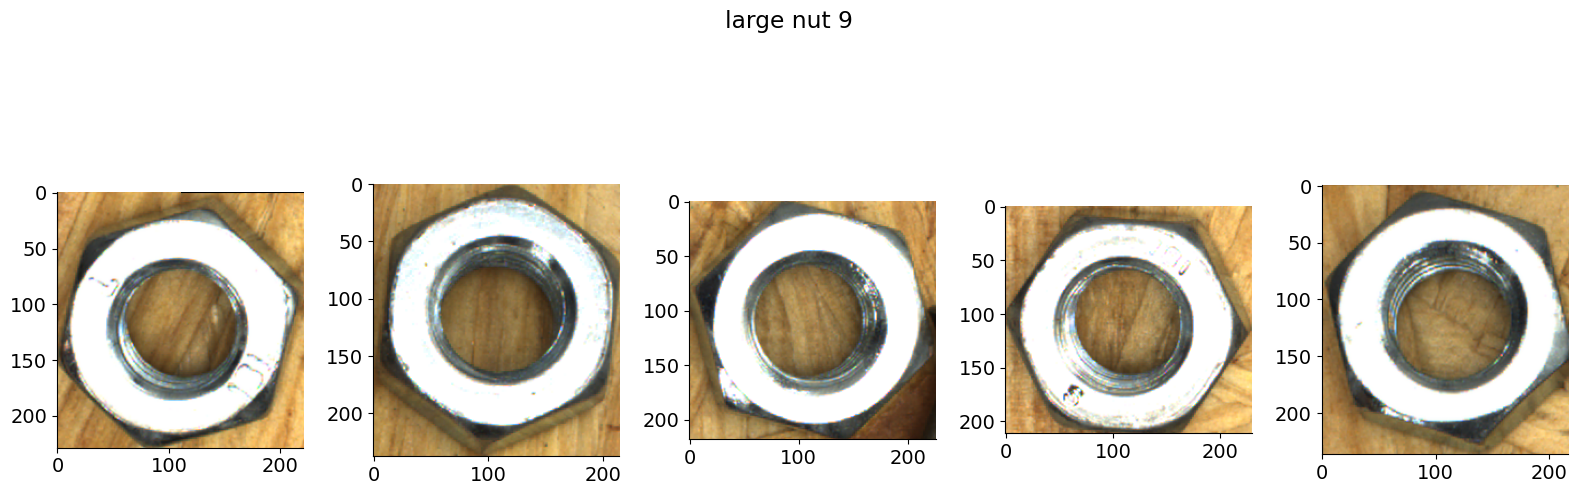

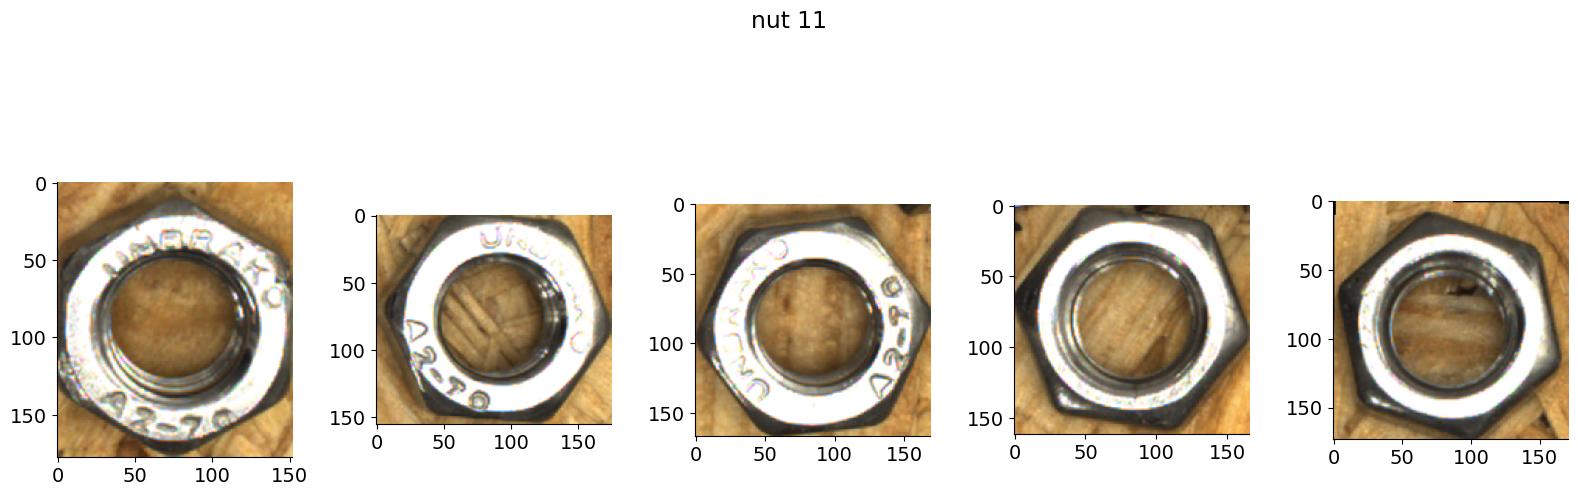

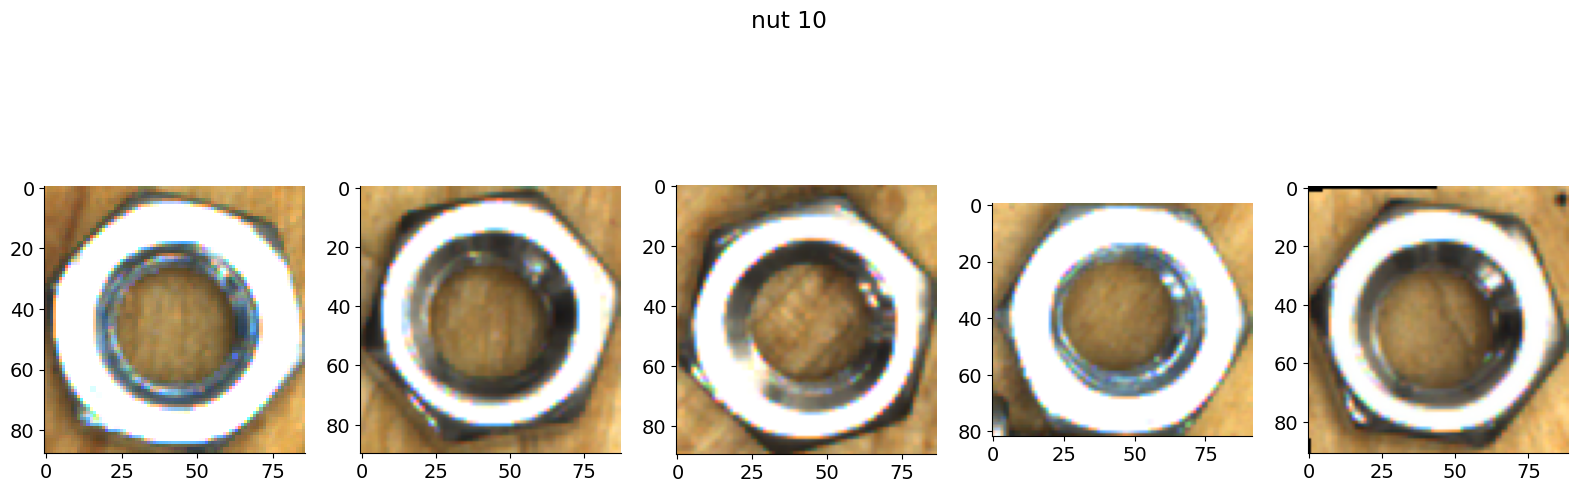

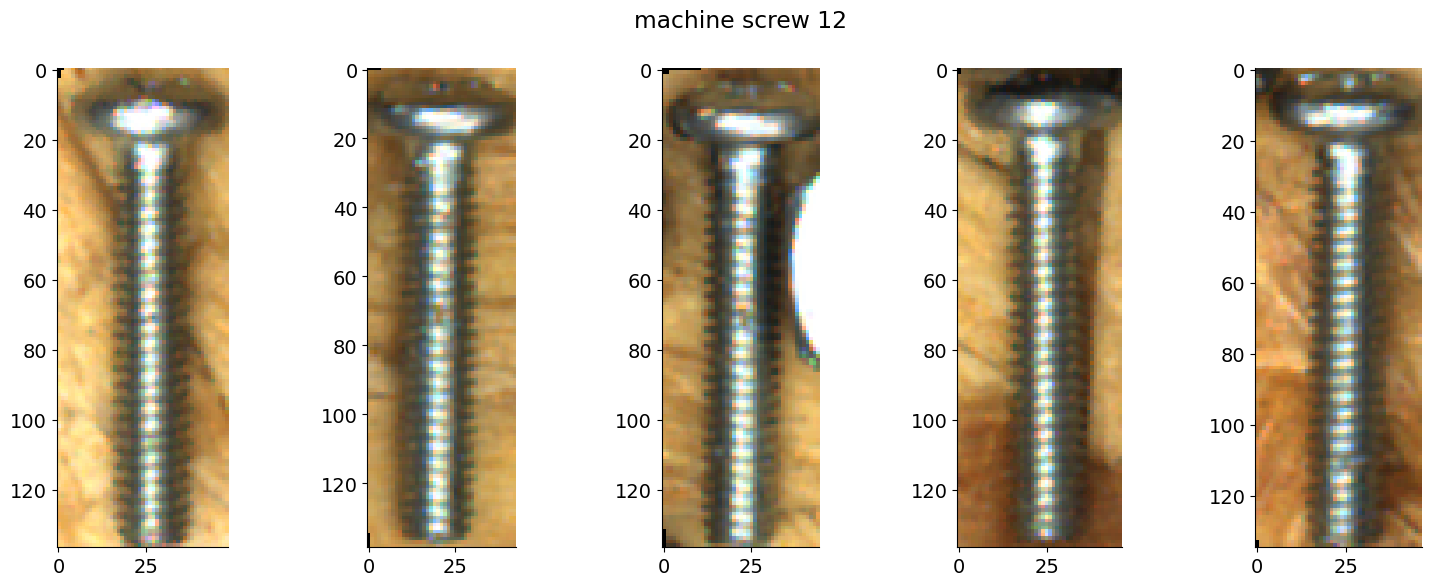

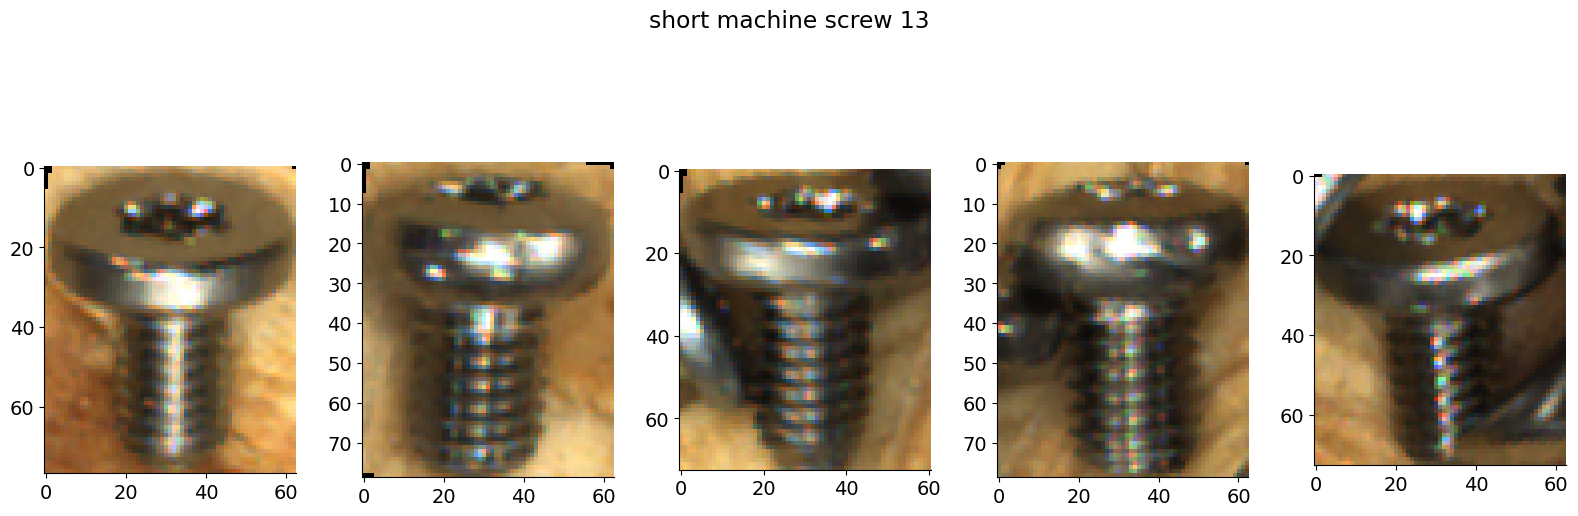

In [24]:
# Plot some examples from each category
for catid, examples in cat_imgdict.items():
  num_examples = 5
  gs = gridspec.GridSpec(1, num_examples)
  plt.figure()
  for i, example in enumerate(examples[:num_examples]):
    plt.subplot(gs[i])
    plt.imshow(example)
    plt.suptitle(f"{category_names[catid]} {catid}")

---
# Object classification 

## Setting up for our first challenge


The challenge of detecting hetergogenously sized objects scattered throughout an image can be challenging, so let's start with something simpler - detecting whether a fixed sized image contains a nut or is blank.

C:\Users\jense\anaconda3\envs\mmyolo\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


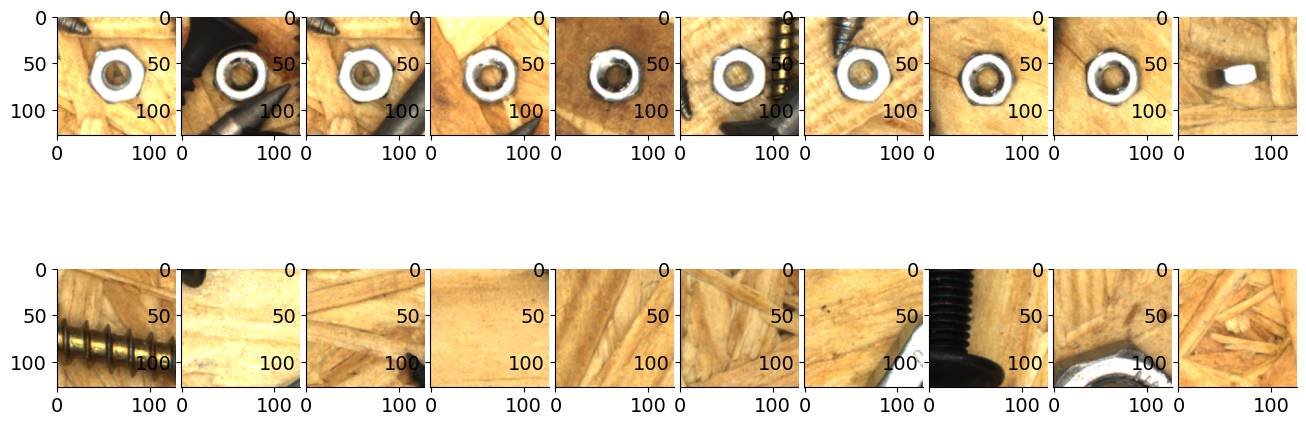

In [25]:
# Start with fixed sized patches that either have a screw or not
use_categories = [7, 10]
# for screw patches use categories that have smaller bounding boxes
patch_size = np.array((128, 128))
num_patches_per_category = 500

nut_patches = []
for img_id, image in imgdict.items():
  for annotation in annodict[img_id]:
    if annotation['category_id'] in use_categories:
      bbox = annotation['bbox']
      rot_center, width, height, theta = unpack_bbox(bbox)
      subimg = extract_subimg(image['image'], rot_center, patch_size[0], patch_size[1], 0)
      if all(subimg.shape[:2] == patch_size):
        nut_patches.append(subimg)
      # plt.figure()
      # plt.imshow(subimg)

  if len(nut_patches) >= num_patches_per_category:
    break

#Select random blank patches
blank_patches = []
for i in range(len(nut_patches)):
  while True: #until a suitable random patch is found
    #choose random image
    imgid, imgobj = random.choice(list(imgdict.items()))
    im = imgobj['image']
    #choose random place at least half a patch size from edges
    rand_center = np.random.randint((patch_size//2), np.array(im.shape)[:2] - patch_size//2)
    corners = rotcorners_from_coords(rand_center, patch_size[0], patch_size[1], 0)
    #check if the random patch intersects with any labeled objects
    if not any([Polygon(corners).intersects(Polygon(rotcorners_from_coords(*unpack_bbox(annotation['bbox'])))) for annotation in annodict[imgid]]):
      rand_patch = im[rand_center[0]-patch_size[0]//2:rand_center[0]+patch_size[0]//2, rand_center[1]-patch_size[1]//2:rand_center[1]+patch_size[1]//2]
      blank_patches.append(rand_patch)
      break

# TODO seems like rarely the patches aren't fully blank - are some labels missing??

# could also use some images from cifar etc.
num_examples = 10
plt.figure()
gs = gridspec.GridSpec(2, num_examples, wspace=.05)
for i in range(num_examples):
  plt.subplot(gs[0, i])
  plt.imshow(nut_patches[i])
  plt.subplot(gs[1, i])
  plt.imshow(blank_patches[i])

patch_labels = [1,]*len(nut_patches) + [0,]*len(blank_patches)  #1 if nut
all_patches = nut_patches + blank_patches #list concat

# randomly shuffle
shuffle_idx = np.random.choice(len(patch_labels), len(patch_labels), replace=False)
patch_labels = [patch_labels[i] for i in shuffle_idx]
all_patches = [all_patches[i] for i in shuffle_idx]

In [26]:
# Check shapes are correct
# assert all([p.shape == (128,128,3) for p in all_patches])
[i for i,p in enumerate(all_patches) if p.shape != (128, 128, 3)]

[]

## Preparing our first network
Before immediately jumping into coding a network, first think about what the structure of the network should look like. 
Hint - it's often helpful to start thinking about the shape/dimensionality of the inputs and outputs 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


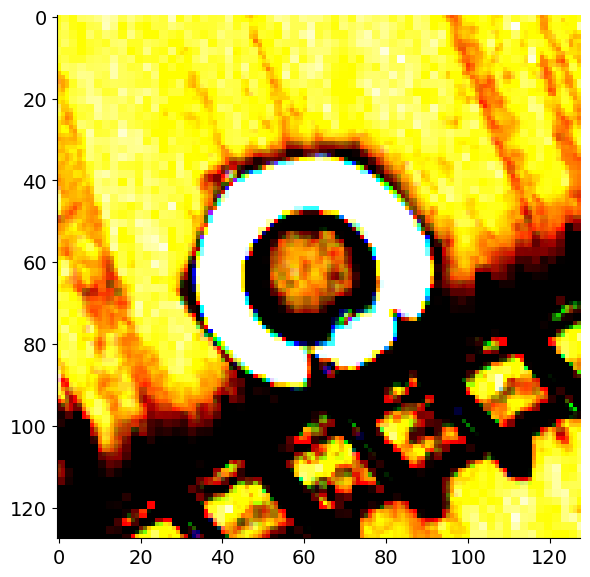

In [27]:
# Preprocess data
preprocess = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_frac = .2
train_number = int(len(all_patches)*train_frac)
# test_nuumber = all_patches.len()-train_number
train_patches, train_labels = all_patches[:train_number], patch_labels[:train_number]
test_patches, test_labels = all_patches[train_number:], patch_labels[train_number:]

plt.figure()
plt.imshow(preprocess(all_patches[0]).permute(1, 2, 0))
plt.show()

In [28]:
class SimpleScrewNet(nn.Module):
  def __init__(self):
    super().__init__()

    LeakyReLU = nn.LeakyReLU()
    MaxPool2d = nn.MaxPool2d(2, stride=2)
    self.layers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=7, stride=2),
        LeakyReLU,
        MaxPool2d,

        nn.Conv2d(16, 32, kernel_size=5),
        # nn.Conv2d(32, 32, kernel_size=5),
        LeakyReLU,
        MaxPool2d,

        nn.Conv2d(32, 64, kernel_size=5),
        LeakyReLU,
        MaxPool2d,

        nn.Flatten(1),

        nn.Linear(1024, 64),
        # nn.Dropout(),
        nn.Linear(64, 2),

        # nn.Conv2d(3, 6, 5),
        # nn.MaxPool2d(2, 2),
        # nn.Conv2d(6, 16, 5),
        # nn.Linear(16 * 5 * 5, 120),
        # nn.Linear(120, 84),
        # nn.Linear(84, 2),

    )

  def forward(self, x):
    # Simply pass the data through the layers
    return self.layers(x)

In [29]:
# Inspect model structure and layer sizes
snet = SimpleScrewNet().to(device)
summary(snet, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 61, 61]           2,368
         LeakyReLU-2           [-1, 16, 61, 61]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 26, 26]          12,832
         LeakyReLU-5           [-1, 32, 26, 26]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7             [-1, 64, 9, 9]          51,264
         LeakyReLU-8             [-1, 64, 9, 9]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                   [-1, 64]          65,600
           Linear-12                    [-1, 2]             130
Total params: 132,194
Trainable params: 132,194
Non-trainable params: 0
-------------------------------

In [30]:
# Loss
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(snet.parameters(),lr=0.000001,momentum=0.3)

In [31]:
# Train
num_epoch = 10
train_losses= []  # loss per epoch
test_losses= []  # loss per epoch
test_corrects = []  # % correct per epoch

test_correct = []
with torch.no_grad():
  for img,lbl in zip(test_patches, test_labels):
    img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).cuda()
    lbl=torch.torch.as_tensor(lbl).unsqueeze(0).cuda()
    predict=snet(img)
    test_correct.append((predict.argmax() == lbl).item())
test_correct = np.array(test_correct)
print(f'Before starting: {test_correct.mean()*100:.2f}% of test images correct')

for epoch in range(num_epoch):
  train_loss=0.0
  test_loss=0.0
  test_correct = []

  snet.train()
  # for img,lbl in train_ds_loader:
  for img,lbl in zip(train_patches, train_labels):
    img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).cuda()
    lbl=torch.torch.as_tensor(lbl).unsqueeze(0).cuda()

    optimizer.zero_grad()
    # print(img.shape)
    predict=snet(img)
    loss=loss_fn(predict,lbl)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()*img.size(0)

  with torch.no_grad():
    for img,lbl in zip(test_patches, test_labels):
      img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).cuda()
      lbl=torch.torch.as_tensor(lbl).unsqueeze(0).cuda()
      predict=snet(img)
      loss=loss_fn(predict,lbl)
      test_loss+=loss.item()*img.size(0)
      test_correct.append((predict.argmax() == lbl).item())

  test_correct = np.array(test_correct).mean()
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  test_corrects.append(test_correct)
  print('Epoch:{} Train Loss:{:.3f} Test Losss:{:.3f} Percent correct: {:.2f}%'.format(epoch,train_loss,test_loss, test_correct*100))

Before starting: 50.00% of test images correct
Epoch:0 Train Loss:90.933 Test Losss:172.039 Percent correct: 96.13%
Epoch:1 Train Loss:30.697 Test Losss:138.606 Percent correct: 97.01%
Epoch:2 Train Loss:24.359 Test Losss:117.073 Percent correct: 97.63%
Epoch:3 Train Loss:20.174 Test Losss:102.151 Percent correct: 98.25%
Epoch:4 Train Loss:17.208 Test Losss:91.113 Percent correct: 98.38%
Epoch:5 Train Loss:15.008 Test Losss:82.701 Percent correct: 98.38%
Epoch:6 Train Loss:13.317 Test Losss:76.052 Percent correct: 98.63%
Epoch:7 Train Loss:11.974 Test Losss:70.742 Percent correct: 98.63%
Epoch:8 Train Loss:10.896 Test Losss:66.361 Percent correct: 98.63%
Epoch:9 Train Loss:10.000 Test Losss:62.708 Percent correct: 98.63%


In [34]:
# calculate percentage correct
correct = []
with torch.no_grad():
  for img,lbl in zip(test_patches, test_labels):
    img=torch.from_numpy(img).float().permute(2,1,0).unsqueeze(0).to(device)
    lbl=torch.torch.as_tensor(lbl).unsqueeze(0).to(device)
    predict=snet(img)
    correct += [(predict.argmax() == lbl).item()]
correct = np.array(correct)
print(f'{correct.mean()*100:.3f}% of test images correct')

98.628% of test images correct


Text(0, 0.5, 'Loss')

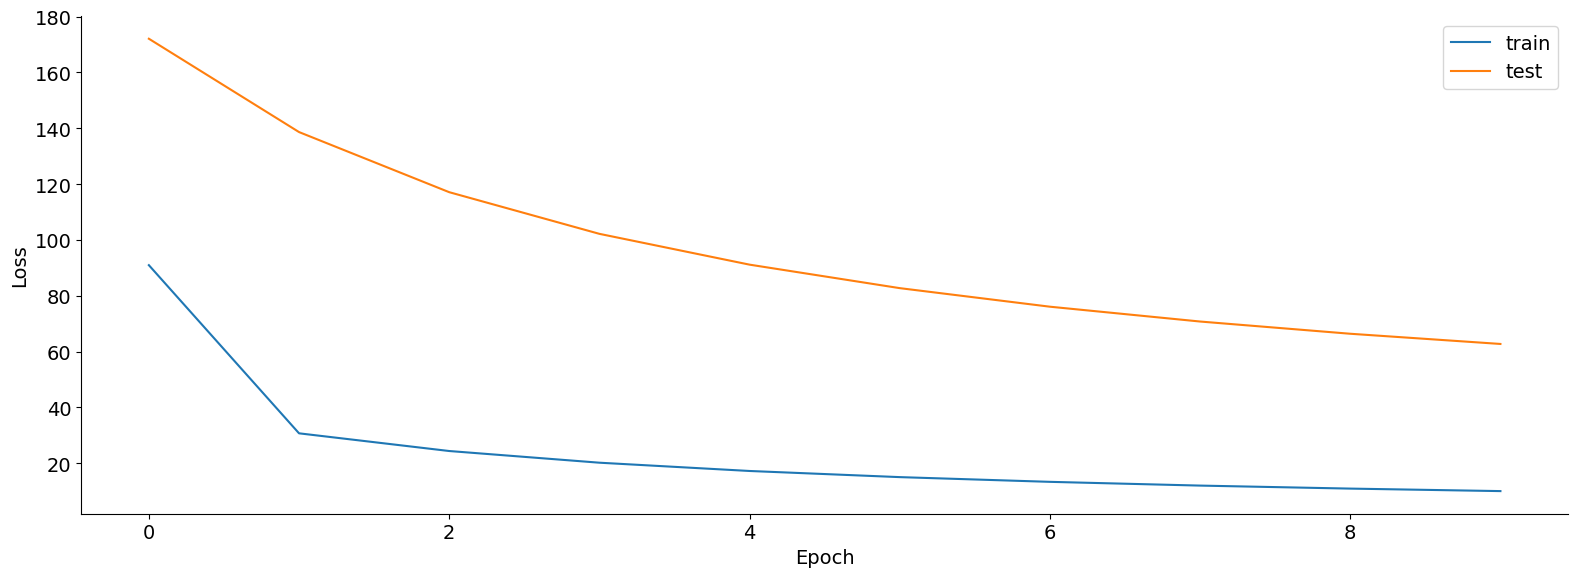

In [33]:
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Damaged screw detection

There's a dataset with anamolous screws on Kaggle - [https://www.kaggle.com/ruruamour/screw-dataset](https://www.kaggle.com/ruruamour/screw-dataset) 

Download and inspect the dataset, then setup a network for classification of damaged or normal screw

```python
import json, os
# Here's a code snippet for downloading from kaggle
dirname = '~/.kaggle/' 
os.mkdir(dirname)

file_path = f"{dirname}{'kaggle.json'}"
# create an empty file
with open(file_path, 'w') as fp:
  pass

# create/download api token from Kaggle -> upper right side -> account -> API -> create API token, and copy it here
api_token = {"username":"username here","key":"enter api key here"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

# chnage permissions
s = '600'
os.chmod(file_path, int(s, base=8))

# download
!kaggle datasets download -d ruruamour/screw-dataset
```

## Multi-class classification
So far we've been doing object classification on single classes from the dataset. 
Change your network to use the 13 classes from the original dataset to classify images of fixed sized into the 13 classes. 
Note that not all classes are the same sized, so you'll have to use larger image patches and likely change the configuration of your network some. 


In [ ]:
# Reminder, you can use extract_subimg(im, rot_center, width, height, theta) to extract image patches

---
# Object detection

Object classification of fixed sized images with a single item is nice, but for many real world tasks detection of multiple objects throughout an image is crucial. Now we will try to create a network for object detection. 

Here's a useful intro to some of the different types of object classification tasks: 
[https://machinelearningmastery.com/object-recognition-with-deep-learning/](https://machinelearningmastery.com/object-recognition-with-deep-learning/)

First start by thinking about how the network could capture the location of multiple objects - a single classifer layer at the end of the network won't be enough. The [YOLO paper](https://arxiv.org/abs/1506.02640) might be a helpful read as well as [this algorithm comparison](https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e). 
Try to implement your own network (keep in mind for a practice training time you won't be able to use as deep of a network as many of the papers). 

## Network performance/introspection


An important skill for deep learning, as well as any data or programming task is to know how to inspect and debug the performance of your system. 
Check out what your intermediate layers are actually learning - does this give you any hints to improve your performance? 
The [W1D2 tutorial](https://deeplearning.neuromatch.io/tutorials/W1D2_LinearDeepLearning/student/W1D2_Tutorial3.html) might also be useful.


## Oriented bounding boxes


The standard yolo just draws bounding boxes, and doesn't handle rotated objects elegantly.

There's several works that extend [yolo with oriented boxes](https://github.com/feifeiwei/OBB-YOLOv3) or have other network structures that can produce oriented bounding boxes([see here](https://github.com/yijingru/BBAVectors-Oriented-Object-Detection)).

## Class clustering


We've been using provided labels to define our object classes (a form of supervised learning). For many datasets you won't labels or they will be incomplete. 

Try unsupervised clustering to segment the data into groups. 
Either classical approaches which [sklearn](https://scikit-learn.org/stable/unsupervised_learning.html) will be very helpful for, or using deep learning approaches ([example 1](https://towardsdatascience.com/image-clustering-implementation-with-pytorch-587af1d14123), [example 2](https://github.com/facebookresearch/deepcluster)).

How do the unsupervised clusters compare with the provided labels?

---
# Perspective and scale

## Transfer Learning

There's many models for object detection/segmentation, for instance: 
[yolo3 minimal](https://github.com/eriklindernoren/PyTorch-YOLOv3), [yolov5](https://github.com/ultralytics/yolov5), [detetectron2](https://github.com/facebookresearch/detectron2), [Scaled-YOLOv4](https://models.roboflow.com/object-detection/scaled-yolov4).

I'd recommend reading the original [YOLO paper](https://arxiv.org/abs/1506.02640) and then starting with [yolo3 minimal](https://github.com/eriklindernoren/PyTorch-YOLOv3) (less performance, but more readable code than the more complicated frameworks).

Starting from one of these pretrained networks train it on your screw dataset. How does it's performance compare to your simpler network's performance?

---
# Useful links
Library of open 3D cad models of bolts etc.: [https://www.bolts-library.org/en/index.html](https://www.bolts-library.org/en/index.html)